In [44]:
from pathlib import Path
from configs.config import MainConfig
from confz import BaseConfig, FileSource
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
from utils.utils import load_detector, load_classificator, open_mapping, extract_crops
import pandas as pd
from itertools import repeat
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [45]:
input_directory_path = '../ml/грозный/2/'
path_to_dataset = './грозный/'

pathes_to_imgs = []
for directory, _, _ in os.walk(path_to_dataset):
    pathes_to_imgs += [i for i in sorted(Path(directory).glob("*"))
                      if i.suffix.lower() in [".jpeg", ".jpg", ".png"]]
pathes_to_imgs[:10]

[PosixPath('грозный/8/05170049.JPG'),
 PosixPath('грозный/8/05170050.JPG'),
 PosixPath('грозный/8/05170051.JPG'),
 PosixPath('грозный/8/05180071.JPG'),
 PosixPath('грозный/8/05180072.JPG'),
 PosixPath('грозный/8/05180077.JPG'),
 PosixPath('грозный/8/05180078.JPG'),
 PosixPath('грозный/8/05180087.JPG'),
 PosixPath('грозный/8/05180088.JPG'),
 PosixPath('грозный/8/05180089.JPG')]

In [46]:
main_config = MainConfig(config_sources=FileSource(file=os.path.join("configs", "config.yml")))
print(main_config)
device = main_config.device

# Load imgs from source dir
# pathes_to_imgs = [i for i in sorted(Path(input_directory_path).glob("*"))
#                   if i.suffix.lower() in [".jpeg", ".jpg", ".png"]]

# Load mapping for classification task
mapping = open_mapping(path_mapping=main_config.mapping)

# Separate main config
detector_config = main_config.detector
classificator_config = main_config.classificator

# Load models
detector = load_detector(detector_config).to(device)
classificator = load_classificator(classificator_config).to(device)

src_dir='data' mapping='class_map_animal.txt' device='cpu' detector=DetectorArgs(weights='weights/detection/yolov8n.pt', iou=0.45, conf=0.4, imgsz=(640, 640), batch_size=1) classificator=ClassificatorArgs(weights='weights/classification/efficientnet_b0.pt', imgsz=(768, 768), batch_size=8)


In [47]:
if len(pathes_to_imgs):

    list_predictions = []

    num_packages_det = np.ceil(len(pathes_to_imgs) / detector_config.batch_size).astype(np.int32)
    with torch.no_grad():
        for i in tqdm(range(num_packages_det), colour="green"):
            # Inference detector
            batch_images_det = pathes_to_imgs[detector_config.batch_size * i:
                                              detector_config.batch_size * (1 + i)]
            results_det = detector(batch_images_det,
                                   iou=detector_config.iou,
                                   conf=detector_config.conf,
                                   imgsz=detector_config.imgsz,
                                   verbose=False,
                                   device=device)
            
            filename = str(batch_images_det[0])[-14:]

            if len(results_det) > 0:
                # Extract crop by bboxes
                dict_crops = extract_crops(results_det, config=classificator_config)

                # Inference classificator
                for img_name, batch_images_cls in dict_crops.items():
                    # if len(batch_images_cls) > classificator_config.batch_size:
                    num_packages_cls = np.ceil(len(batch_images_cls) / classificator_config.batch_size).astype(np.int32)
                    for j in range(num_packages_cls):
                        batch_images_cls = batch_images_cls[classificator_config.batch_size * j:
                                                            classificator_config.batch_size * (1 + j)]
                        logits = classificator(batch_images_cls.to(device))
                        probabilities = torch.nn.functional.softmax(logits, dim=1)
                        top_p, top_class_idx = probabilities.topk(1, dim=1)

                        # Locate torch Tensors to cpu and convert to numpy
                        top_p = top_p.cpu().numpy().ravel()
                        top_class_idx = top_class_idx.cpu().numpy().ravel()

                        class_names = [mapping[top_class_idx[idx]] for idx, _ in enumerate(batch_images_cls)]

                        list_predictions.extend([[filename, cls, prob] for name, cls, prob in
                                                 zip(repeat(img_name, len(class_names)), class_names, top_p)])

  0%|          | 0/847 [00:00<?, ?it/s]

In [98]:
predictions = pd.DataFrame(list_predictions, columns=["link", "class_name_predicted", "confidence"])
predictions.to_csv('predictions.csv', index=False)
predictions

,link,class_name_predicted,confidence
0,8/05170049.JPG,Empty,0.859271
1,8/05170050.JPG,Empty,0.841817
2,8/05180077.JPG,Empty,0.855297
3,8/05180078.JPG,Empty,0.850723
4,8/05180087.JPG,Empty,0.855770
...,...,...,...
1057,2/IMG_1198.JPG,Empty,0.775473
1058,2/IMG_1200.JPG,Empty,0.485974
1059,2/IMG_1201.JPG,Empty,0.885605
1060,2/IMG_1209.JPG,Empty,0.836772


<Axes: xlabel='class_name_predicted'>

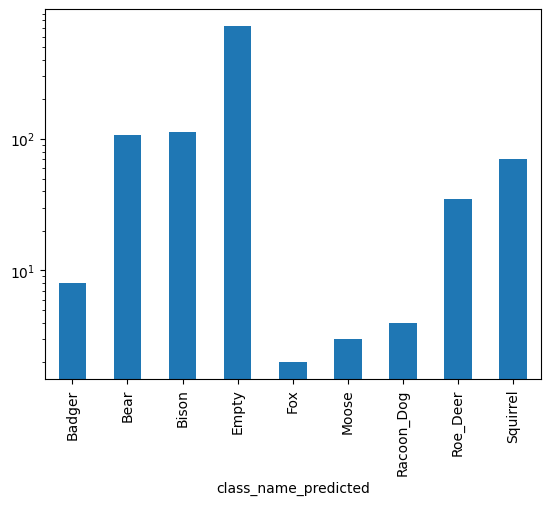

In [49]:
plt.yscale('log')
predictions.groupby('class_name_predicted').agg('size').plot(kind='bar')

In [50]:
registrations = pd.read_csv('registration.csv')
registrations

,name_folder,name,class_predict,date_registration,bbox,registrations_id,registration_class,count,max_count,flag,link
0,1,Im_0011814.jpg,Bear,2020-07-22 07:02:52,1336 365 2048 1186,registration 000001 2.0,Bear,1.0,2.0,0 days 00:27:35,1/IMG_0004.JPG
1,1,Im_0011850.jpg,Bear,2020-07-22 07:02:55,717 322 1949 1293,registration 000001 2.0,Bear,1.0,2.0,0 days 00:27:35,1/IMG_0005.JPG
2,1,Im_0011785.jpg,Bear,2020-07-22 07:02:58,724 264 1950 1293,registration 000001 2.0,Bear,1.0,2.0,0 days 00:27:35,1/IMG_0006.JPG
3,1,Im_0011864.jpg,Bear,2020-07-22 07:29:05,560 338 1496 1428,registration 000001 2.0,Bear,2.0,2.0,0 days 00:27:35,1/IMG_0013.JPG
4,1,Im_0011870.jpg,Bear,2020-07-22 07:29:08,598 400 1504 1426,registration 000001 2.0,Bear,1.0,2.0,0 days 00:27:35,1/IMG_0014.JPG
...,...,...,...,...,...,...,...,...,...,...,...
21008,9,Im_0010864.jpg,Musk_Deer,2020-05-17 20:03:33,1569 1016 2173 1871,registration 002172 1.0,Roe_Deer,NaN,1.0,0 days 00:28:21,9/IMAG0706.JPG
21009,9,Im_0010782.jpg,Musk_Deer,2020-05-17 20:08:26,1605 1083 2318 1857,registration 002172 1.0,Roe_Deer,NaN,1.0,0 days 00:28:21,9/IMAG0707.JPG
21010,9,Im_0010913.jpg,Musk_Deer,2020-05-17 20:08:31,1610 1068 2327 1862,registration 002172 1.0,Roe_Deer,NaN,1.0,0 days 00:28:21,9/IMAG0708.JPG
21011,9,Im_0010867.jpg,Roe_Deer,2020-05-17 20:26:32,1914 1213 2206 1821,registration 002172 1.0,Roe_Deer,1.0,1.0,0 days 00:28:21,9/IMAG0709.JPG


In [51]:
df = predictions.merge(registrations, on='link', how='inner')
df

,link,class_name_predicted,confidence,name_folder,name,class_predict,date_registration,bbox,registrations_id,registration_class,count,max_count,flag
0,8/05170049.JPG,Empty,0.859271,8,Im_0012725.jpg,Moose,2020-05-17 03:49:52,1857 960 2530 1822,registration 002098 1.0,Moose,1.0,1.0,0 days 00:17:06
1,8/05170050.JPG,Empty,0.841817,8,Im_0012809.jpg,Moose,2020-05-17 03:49:53,1854 971 2512 1834,registration 002098 1.0,Moose,1.0,1.0,0 days 00:17:06
2,8/05180077.JPG,Empty,0.855297,8,Im_0012890.jpg,Roe_Deer,2020-05-18 11:35:05,1673 1334 2311 2213,registration 002100 1.0,Roe_Deer,1.0,1.0,0 days 00:00:01
3,8/05180078.JPG,Empty,0.850723,8,Im_0012740.jpg,Roe_Deer,2020-05-18 11:35:06,1661 1334 2317 2213,registration 002100 1.0,Roe_Deer,1.0,1.0,0 days 00:00:01
4,8/05180087.JPG,Empty,0.855770,8,Im_0012747.jpg,Roe_Deer,2020-05-18 18:00:24,2254 1184 3300 2219,registration 002101 1.0,Roe_Deer,1.0,1.0,0 days 00:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,2/IMG_1198.JPG,Empty,0.775473,2,Im_0012416.jpg,Wolf,2020-07-10 04:17:30,1211 32 1646 270,registration 000647 2.0,Fox,NaN,2.0,0 days 00:10:30
1015,2/IMG_1200.JPG,Empty,0.485974,2,Im_0012332.jpg,Wolf,2020-07-10 04:17:31,1380 30 1920 365,registration 000647 2.0,Fox,NaN,2.0,0 days 00:10:30
1016,2/IMG_1201.JPG,Empty,0.885605,2,Im_0012558.jpg,Cat,2020-07-10 07:42:14,465 335 1263 1041,registration 000648 1.0,Fox,NaN,1.0,0 days 00:02:00
1017,2/IMG_1209.JPG,Empty,0.836772,2,Im_0012573.jpg,Fox,2020-07-10 07:44:13,177 28 667 318,registration 000648 1.0,Fox,1.0,1.0,0 days 00:02:00


In [52]:
correct_predictions = (df['class_name_predicted'] == df['class_predict']).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions
print(accuracy)

0.20902845927379785


In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'Confusion Matrix')

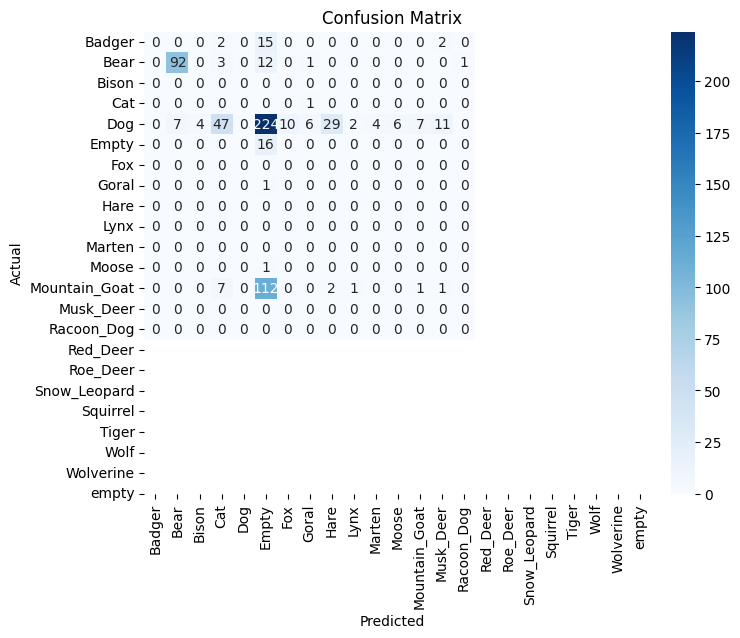

In [26]:
cm = confusion_matrix(df['class_name_predicted'], df['class_predict'])

classnames = [val for _, val in mapping.items()]
classnames.append('empty')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classnames, yticklabels=classnames)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [53]:
def get_date_taken(path):
    exif = Image.open(path)._getexif()
    if not exif:
        raise Exception('Image {0} does not have EXIF data.'.format(path))
    return datetime.strptime(exif[36867], '%Y:%m:%d %H:%M:%S')

In [54]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [55]:
def generate_registrations(predictions):
    # name_folder,class,date_registration_start,date_registration_end,count
    registrations = []
    
    predictions['name_folder'] = predictions['link'].apply(lambda x: x[:x.find('/')])
    for name_folder, group in predictions.groupby('name_folder'):
        dates = []
        classes = []
        counts = []
        for shortpath, obj in group.groupby('link'):
            path = path_to_dataset+shortpath
            
            counts.append(min(len(obj), 5))
            dates.append(get_date_taken(path))
            
            cls = []
            for id, obj in obj.iterrows():
                cls.append(obj['class_name_predicted'])
            classes.append(cls)
        # print(dates[:5])
        # print(counts[:5])
        # print(classes[:5])

        prev_date = dates[0]
        prev_class = most_common(classes[0])
        prev_count = counts[0]
        registrations.append({
            'name_folder': name_folder, 
            'class': prev_class,
            'classdate_registration_start': prev_date, 
            'date_registration_end': prev_date, 
            'count': prev_count,
        })
        for i, (date, cls, count) in enumerate(zip(dates[1:], classes[1:], counts[1:])):
            cls = most_common(cls)

            if cls == prev_class and count == prev_count and (date - prev_date).seconds//3600 < 30:
                registrations[-1]['date_registration_end'] = date
            else:
                registrations.append({
                    'name_folder': name_folder, 
                    'class': cls,
                    'classdate_registration_start': date, 
                    'date_registration_end': date, 
                    'count': count,
                })
            
            prev_date = date
            prev_class = cls
            prev_count = count
        registrations[-1]['date_registration_end'] = date
        
    return registrations

In [59]:
predictions['link'] = predictions['link'].apply(lambda x: x if x[0] != '0' else '1'+x)
predictions['link']

0       8/05170049.JPG
1       8/05170050.JPG
2       8/05180077.JPG
3       8/05180078.JPG
4       8/05180087.JPG
             ...      
1057    2/IMG_1198.JPG
1058    2/IMG_1200.JPG
1059    2/IMG_1201.JPG
1060    2/IMG_1209.JPG
1061    2/IMG_1210.JPG
Name: link, Length: 1062, dtype: object

In [60]:
regs = generate_registrations(predictions)
regs

[{'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 2, 52),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 2, 58),
  'count': 1},
 {'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 29, 5),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 29, 11),
  'count': 2},
 {'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 29, 42),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 30, 21),
  'count': 1},
 {'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 30, 24),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 30, 27),
  'count': 2},
 {'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 17, 31, 6),
  'date_registration_end': datetime.datetime(2020, 7, 23, 8, 39, 13),
  '

In [73]:
def get_sliding_window(dates, i, minutes):
    left = i
    right = i

    while left > 0 and (dates[i]-dates[left]).seconds // 60 < minutes:
        left -= 1
    while right < len(dates)-1 and (dates[right]-dates[i]).seconds // 60 < minutes:
        right += 1
    return left, right

In [96]:
def generate_registrations_with_windows(predictions):
    # name_folder,class,date_registration_start,date_registration_end,count
    registrations = []
    
    predictions['name_folder'] = predictions['link'].apply(lambda x: x[:x.find('/')])
    for name_folder, group in predictions.groupby('name_folder'):
        dates = []
        classes = []
        counts = []
        for shortpath, obj in group.groupby('link'):
            path = path_to_dataset+shortpath
            
            counts.append(min(len(obj), 5))
            dates.append(get_date_taken(path))
            
            cls = []
            for id, obj in obj.iterrows():
                cls.append(obj['class_name_predicted'])
            classes.append(most_common(cls))

        prev_date = dates[0]
        prev_class = most_common(classes[0])
        prev_count = counts[0]
        registrations.append({
            'name_folder': name_folder, 
            'class': prev_class,
            'classdate_registration_start': prev_date, 
            'date_registration_end': prev_date, 
            'count': prev_count,
        })
        for i, (date, cls, count) in enumerate(zip(dates[1:], classes[1:], counts[1:])):
            left, right = get_sliding_window(dates, i, 30)            

            curr_count = np.max(counts[left:i+1])
            curr_class = most_common(classes[left:right+1])
            
            if curr_class == prev_class and curr_count == prev_count and (dates[i] - prev_date).seconds//60 < 40:
                registrations[-1]['date_registration_end'] = date
            else:
                registrations.append({
                    'name_folder': name_folder, 
                    'class': cls,
                    'classdate_registration_start': date, 
                    'date_registration_end': date, 
                    'count': count,
                })
            
            prev_date = dates[i]
            prev_class = curr_class
            prev_count = curr_count
            if i == 3:
                break
        registrations[-1]['date_registration_end'] = date
        
    return registrations

In [97]:
generate_registrations_with_windows(predictions)

[{'name_folder': '1',
  'class': 'e',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 2, 52),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 2, 52),
  'count': 1},
 {'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 2, 55),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 29, 5),
  'count': 1},
 {'name_folder': '1',
  'class': 'Bear',
  'classdate_registration_start': datetime.datetime(2020, 7, 22, 7, 29, 8),
  'date_registration_end': datetime.datetime(2020, 7, 22, 7, 29, 8),
  'count': 2},
 {'name_folder': '10',
  'class': 'e',
  'classdate_registration_start': datetime.datetime(2020, 4, 20, 9, 52, 24),
  'date_registration_end': datetime.datetime(2020, 4, 20, 9, 52, 24),
  'count': 1},
 {'name_folder': '10',
  'class': 'Roe_Deer',
  'classdate_registration_start': datetime.datetime(2020, 4, 20, 9, 52, 24),
  'date_registration_end': datetime.datetime(2020, 4, 20, 9, 53, 7),
  'coun

In [113]:
def save_registrations(regs, out='submission.csv'):
    df = pd.DataFrame(regs)
    df.to_csv(out, index=False)
    print(f'Saved to {out}')

In [114]:
save_registrations(regs)

Saved to submission.csv


In [107]:
mapping

{0: 'Badger',
 1: 'Bear',
 2: 'Bison',
 3: 'Cat',
 4: 'Dog',
 5: 'Empty',
 6: 'Fox',
 7: 'Goral',
 8: 'Hare',
 9: 'Lynx',
 10: 'Marten',
 11: 'Moose',
 12: 'Mountain_Goat',
 13: 'Musk_Deer',
 14: 'Racoon_Dog',
 15: 'Red_Deer',
 16: 'Roe_Deer',
 17: 'Snow_Leopard',
 18: 'Squirrel',
 19: 'Tiger',
 20: 'Wolf',
 21: 'Wolverine'}

# Анализ данных

<Axes: xlabel='class_predict'>

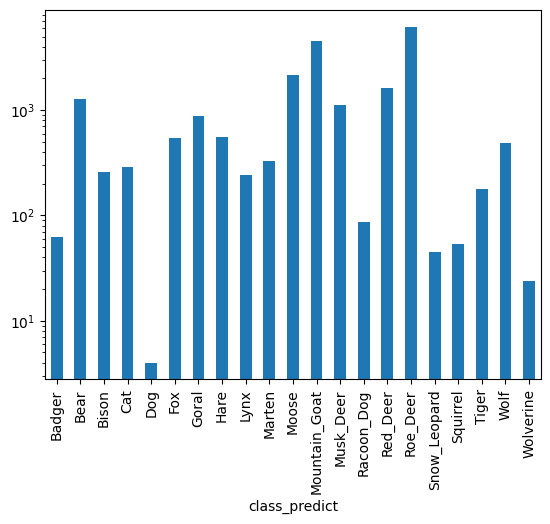

In [19]:
plt.yscale('log')
registrations.groupby('class_predict').agg('size').plot(kind='bar')

<Axes: xlabel='count'>

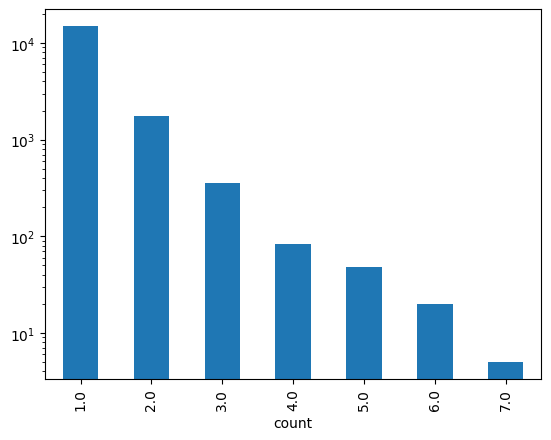

In [18]:
plt.yscale('log')
registrations.groupby('count').agg('size').plot(kind='bar')

# Использование CLIP

In [4]:
import clip

In [5]:
clip_model, preprocessor = clip.load("ViT-B/32", device=device)
clip_model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [38]:
def predict_with_clip(pathes_to_imgs, queries, labels):
    if len(pathes_to_imgs) == 0:
        return

    tokenized_queries = [clip.tokenize(query).to(device) for query in queries]
    text_embeddings = [clip_model.encode_text(tq) for tq in tokenized_queries]
    for i in range(len(text_embeddings)):
        text_embeddings[i] = text_embeddings[i].mean(dim=0, keepdim=True)
        text_embeddings[i] = F.normalize(text_embeddings[i], p=2, dim=-1)
    
    list_predictions = []

    num_packages_det = np.ceil(len(pathes_to_imgs) / 1).astype(np.int32)
    with torch.no_grad():
        for i in tqdm(range(num_packages_det), colour="green"):
            # Inference detector
            batch_images_det = pathes_to_imgs[1 * i:
                                              1 * (1 + i)]
            results_det = detector(batch_images_det,
                                   iou=detector_config.iou,
                                   conf=detector_config.conf,
                                   imgsz=detector_config.imgsz,
                                   verbose=False,
                                   device=device)
            filename = '/'.join(str(batch_images_det[0]).split('/')[-2:])

            if len(results_det) > 0:
                # Extract crop by bboxes
                dict_crops = extract_crops(results_det, config=classificator_config)

                # Inference classificator
                for img_name, batch_images_cls in dict_crops.items():
                    
                    # if len(batch_images_cls) > classificator_config.batch_size:
                    num_packages_cls = np.ceil(len(batch_images_cls) / classificator_config.batch_size).astype(np.int32)
                    for j in range(num_packages_cls):
                        batch_images_cls = batch_images_cls[classificator_config.batch_size * j:
                                                            classificator_config.batch_size * (1 + j)]

                        class_names = []
                        similarities = []
                        for cropped_image_ in batch_images_cls:
                            cropped_image = preprocessor(transforms.functional.to_pil_image(cropped_image_)).unsqueeze(0).to(device)

                            best_label = -1
                            max_similarity = -np.inf
                            for text_emb, label in zip(text_embeddings, labels):
                                image_emb = clip_model.encode_image(cropped_image)
                                image_emb = F.normalize(image_emb, p=2, dim=-1)
    
                                similarity = torch.dot(image_emb.view(-1), text_emb.view(-1))
                                if similarity > max_similarity:
                                    max_similarity = similarity
                                    best_label = label
                            class_names.append(best_label)
                            similarities.append(max_similarity.item())

                        list_predictions.extend([[filename, cls, prob] for cls, prob in
                                                 zip(class_names, similarities)])
                break
    return list_predictions

In [39]:
queries = [
    [
        'a raindeer',
        'a brown deer',
        'a brown raindeer eats grass',
        'a raindeer curiously walks'
    ]
    ,
    [
        'a dog',
        'a dog runs',
        'a fat dog lays on ground'
    ]
]

labels = ['raindeer', 'dog']
print(classificator_config)
predict_with_clip(pathes_to_imgs, queries, labels)

weights='weights/classification/efficientnet_b0.pt' imgsz=(768, 768) batch_size=8


  0%|          | 0/505 [00:00<?, ?it/s]

[['1/IMG_0004.JPG', 'raindeer', 0.2608893811702728]]

In [42]:
import json
with open('clip_configuration.json', 'w') as file:
    json.dump({'labels': labels, 'queries': queries}, file, indent=4)